# Дипломная работа по курсу "Data Scientist. ML. Средний уровень (нейронные сети)"

## Загрузка данных и разведочный анализ.

In [93]:
# load libraries
from pathlib import Path
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

plt.rcParams['figure.facecolor'] = 'white' # for better plots in dark notebook themes

### Загрузим файл с метками классов.

In [2]:
base_dir = Path('dataset')
df = pd.read_csv(base_dir / 'train.csv', index_col=0)
df.head()

,image_path,emotion
0,./train/anger/0.jpg,anger
1,./train/anger/1.jpg,anger
2,./train/anger/10.jpg,anger
3,./train/anger/100.jpg,anger
4,./train/anger/1000.jpg,anger


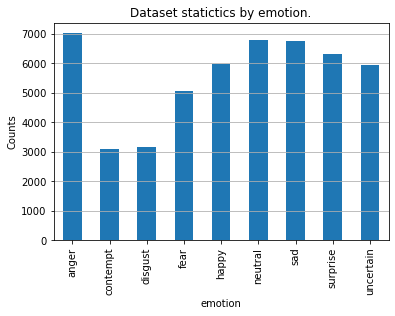

In [3]:
df.groupby('emotion')['image_path'].count().plot.bar()
plt.title('Dataset statictics by emotion.')
plt.ylabel('Counts')
plt.legend().remove(); plt.grid(axis='y')

Дополним датафрейм информацией о формате и размере изображения.

In [4]:
img_info = []
for file in df.image_path:
    with Image.open(base_dir / file) as img:
        (w, h), mode = img.size, img.mode
        img_info.append((h, w, mode))
print('Number of read files:', len(img_info))
df['height'], df['width'], df['mode'] = zip(*img_info)
df['aspect_ratio'] = df['width'] / df['height']

Number of read files: 50046


Немного сухой статистики (выводы ниже)

In [5]:
df.describe(include='all')

,image_path,emotion,height,width,mode,aspect_ratio
count,50046,50046,50046.000000,50046.000000,50046,50046.000000
unique,50046,9,NaN,NaN,1,NaN
top,./train/happy/5806.jpg,anger,NaN,NaN,RGB,NaN
freq,1,7022,NaN,NaN,50046,NaN
mean,NaN,NaN,523.595452,523.587939,NaN,0.999939
std,NaN,NaN,424.975074,425.017862,NaN,0.005394
min,NaN,NaN,133.000000,133.000000,NaN,0.833333
25%,NaN,NaN,247.000000,247.000000,NaN,1.000000
50%,NaN,NaN,371.000000,371.000000,NaN,1.000000
75%,NaN,NaN,660.000000,660.000000,NaN,1.000000


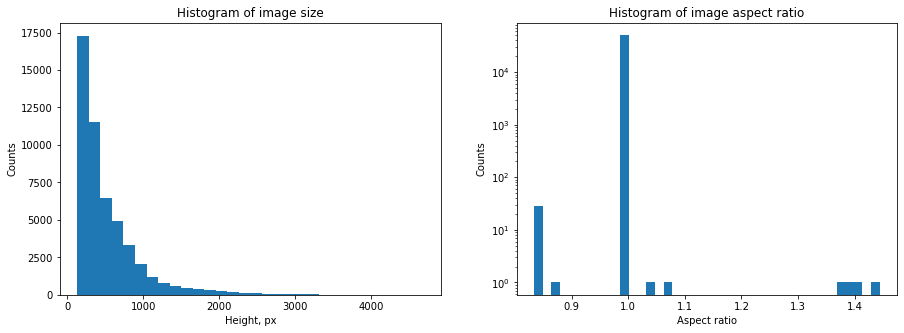

In [6]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df.height, bins=30)
plt.title('Histogram of image size')
plt.xlabel('Height, px'); plt.ylabel('Counts')
plt.subplot(1, 2, 2)
plt.hist(df.aspect_ratio, bins=40, log=True)
plt.title('Histogram of image aspect ratio')
plt.xlabel('Aspect ratio'); plt.ylabel('Counts')
plt.show()

Дополнительный код для отображения фотографий и визуализации результата детектирования лиц:

In [7]:
# instantiate face detector
folder = 'face_detection_data/'
fd_net =  cv2.dnn.readNetFromCaffe(
                folder + 'opencv_face_detector.prototxt', 
                folder + 'opencv_face_detector.caffemodel'
            )

def get_faces(image):
    """Run inference of face detector and return list of boxes with faces."""
    (h, w) = image.shape[:2]
 
    # preprocess image, add batch dim, rearrange dimentions (batch,channels,h,w)
    # size, mean and scale are determined by face detector 
    # (https://github.com/opencv/opencv/blob/master/samples/dnn/models.yml)
    blob = cv2.dnn.blobFromImage(
        image=image, 
        scalefactor=1.0,
        size=(300, 300), 
        mean=(104.0, 177.0, 123.0),
        swapRB=True,
    )
    
    # run inference of face detector
    fd_net.setInput(blob)
    detections = fd_net.forward()
    
    # retrieve face boxes
    faces = []
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            faces.append(box.astype("int"))
    return faces

def draw_boxes_PIL(image, boxes):
    """Draw rect with PIL lib."""
    my_image = Image.fromarray(image)
    image_editable = ImageDraw.Draw(my_image)
    for box in boxes:
        startX, startY, endX, endY = box
        image_editable.rectangle([startX, startY, endX, endY], fill=None, outline=(180,0,0), width=3)
    return my_image

def show_data(data, show_labels=True, show_boxes=False):
    """
    Provided with slice of dataframe with filenames, it shows
    corresponding images with labels and/or boxes. 
    Limited to the first 100 images in dataframe.
    """
    if data.shape[0] > 100:
        data = data.head(100)
    grid_size = np.ceil(np.sqrt(data.shape[0])).astype(np.int)
    plt.figure(figsize=(15, 15))
    for i, file in enumerate(data['image_path']):
        with Image.open(base_dir / file) as image:
            plt.subplot(grid_size, grid_size, i+1)
            if show_boxes:
                img_np = np.array(image.convert('RGB'))
                boxes = get_faces(img_np)
                plt.imshow(draw_boxes_PIL(img_np, boxes))
            else:
                plt.imshow(image)
            if show_labels:
                plt.title(data['emotion'].iloc[i])
            plt.xticks([]); plt.yticks([])
    plt.show()

Посмотрим на "неквадратные" фотографии.

Photos with album orientation.


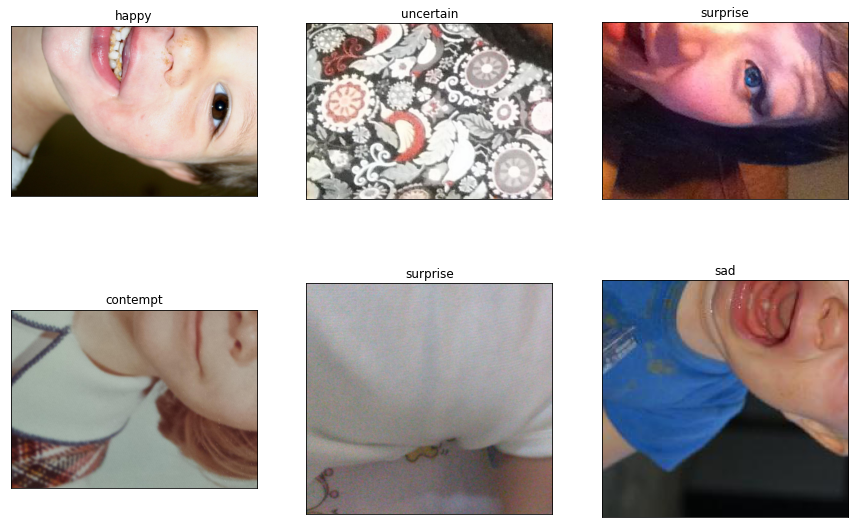

In [8]:
print('Photos with album orientation.')
wide_imgs = df[df['aspect_ratio'] > 1.01].sort_values('aspect_ratio', ascending=False)
show_data(wide_imgs)

Photos with portrait orientation.


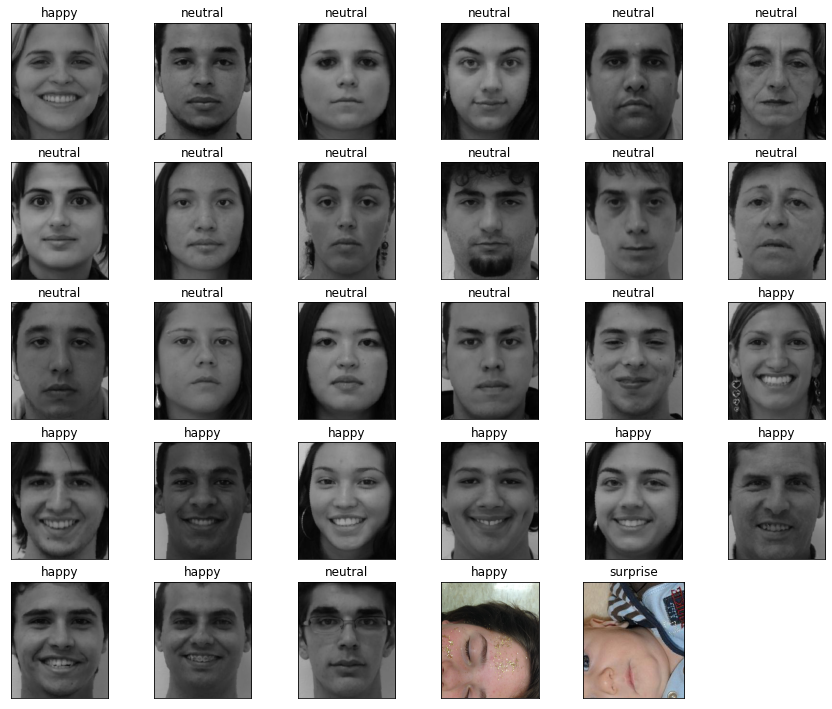

In [9]:
print('Photos with portrait orientation.')
wide_imgs = df[df['aspect_ratio'] < 0.97].sort_values('aspect_ratio', ascending=True)
show_data(wide_imgs)

### Предварительные итоги EDA датасета

- 50046 файлов, все успешно загрузились, все загружаются в формате RGB, хотя некоторые фото и чернобелые.
- Половина изображений имеет размер в пределах 247-660px, минимальный размер 133px, максимальный - 4689px.
- Категории распределены не равномерно: заметный недостаток лиц в категориях contempt и disgust.
- Большинство изображений близки к равным пропорциям ширины и высоты, с некоторыми исключениями, изображенными выше. Заодно видим, что некоторые фотографии даже не являются лицами, либо само лицо сильно обрезано, а некоторые изображения могут быть разревнуты на 90 градусов.

Необходимо либо просмотреть весь датасет и убрать явно дефектные фотографии (где нет лица, лицо сильно обрезано, несколько лиц или фрагментов лиц, неверная ориентация, сторонние артифакты), либо предварительно обработать датасет детектором лиц, и по полученным данным проводить обучение.

Пример обрезки 

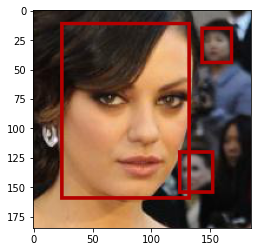

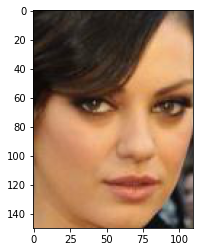

In [10]:
i=25321
file = df['image_path'][i]
with Image.open(base_dir / file) as image:
    img_np = np.array(image.convert('RGB'))
    boxes = get_faces(img_np)
    plt.imshow(draw_boxes_PIL(img_np, boxes))
    plt.show()
    if len(boxes) > 0:
        startW, startH, endW, endH = boxes[0]
        plt.imshow(img_np[startH:endH, startW:endW])
        plt.show()
# с примером 25321 повезло, что box с самым большим лицом имеет индекс 0

Проанализируем все файлы из датасета, определим лицо. Если лицо одно - обрежем его по bounding box'у и сохраним в папке `base_dir/processed/` (сохраняя имя файла и структуру подпапок). Если лиц нет или их больше одного, запишем информацию в `df_err` (индекс, имя файла, количество лиц).

In [ ]:
save_dir = base_dir / 'processed'
save_dir.mkdir(exist_ok=True)

In [11]:
if True: # if it wasn't done yet, change to True

    error_list = []
    counter = 0 # count processed files
    for i, file in tqdm(df['image_path'].items(), total=df.shape[0]):
        with Image.open(base_dir / file) as image:
            img = np.array(image.convert('RGB'))
            # inference of face detector
            boxes = get_faces(img)

            if len(boxes) != 1:
                error_list.append((i, file, len(boxes)))
            else:
                startW, startH, endW, endH = boxes[0]
                face = img[startH:endH, startW:endW]

                # prepare file_name in new folder
                cat_dir = save_dir / Path(file).parent.name
                cat_dir.mkdir(exist_ok=True)
                file_name = cat_dir / Path(file).name

                # save face in a file
                Image.fromarray(face).save(file_name)
                counter += 1

    print(f'A face was detected in {counter} files. {len(error_list)} errors were found.')
    df_err = pd.DataFrame(error_list, columns=['index', 'image_path', 'faces']).set_index('index')
    df_err.to_pickle(base_dir / 'df_eff.pkl')

else:
    df_err = pd.read_pickle(base_dir / 'df_eff.pkl')
    print(f'A face was detected in {df.shape[0] - df_err.shape[0]} files. {len(df_err.shape[0])} errors were found.')

100%|██████████| 50046/50046 [24:17<00:00, 34.33it/s]

A face was detected in 49539 files. 507 errors were found.


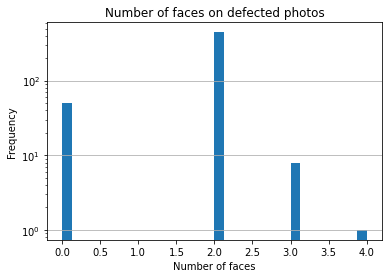

In [21]:
# statistics for amount of detected faces
df_err['faces'].plot.hist(log=True, bins=32)
plt.grid(axis='y'); plt.title('Number of faces on defected photos')
plt.xlabel('Number of faces'); plt.show()

Examples with 0 face detected (51 photos).


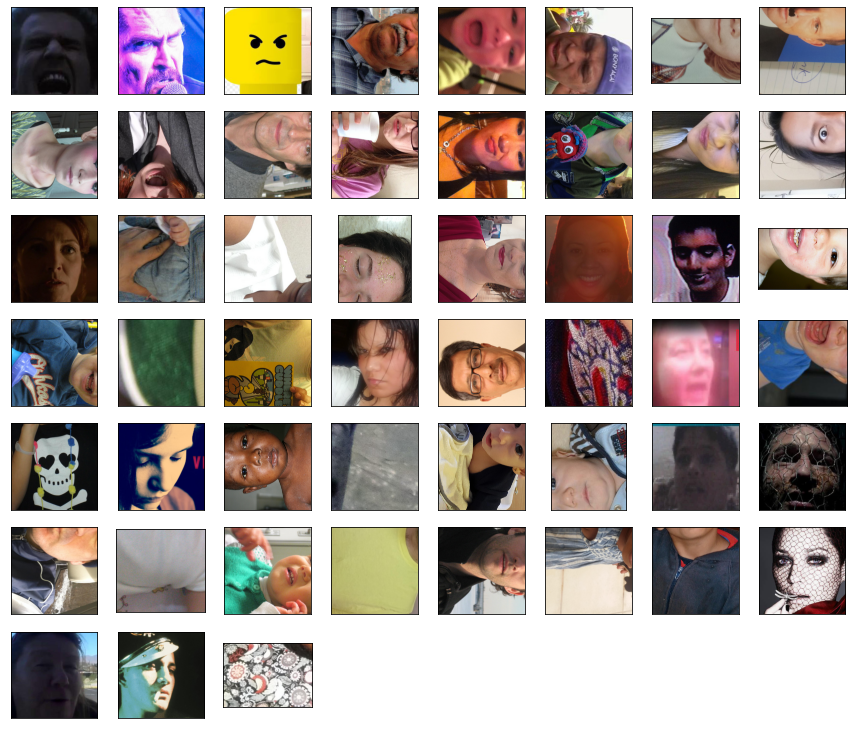

In [22]:
print(f"Examples with 0 face detected ({sum(df_err['faces'] == 0)} photos).")
show_data(df_err[df_err['faces'] == 0], show_labels=False, show_boxes=True)

Photo examples with 2 faces detected.


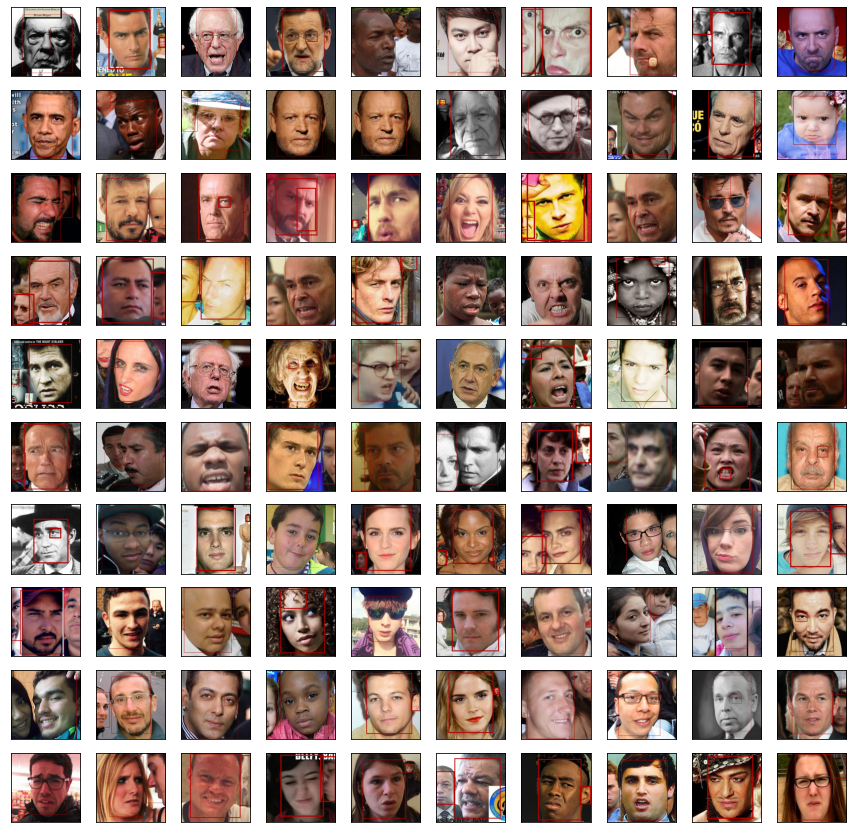

In [23]:
print('Photo examples with 2 faces detected.')
show_data(df_err[df_err['faces'] == 2], show_labels=False, show_boxes=True)

### Выводы из детектирования лиц на исходном датасете

- детектор сделал ошибку в распознавании лица менее, чем в 1% случаев
- около 12 фографий, где лицо не обнаружилось можно было бы оставить (и развернуть, если требуется), но остальные действительно дефектные.
- Большинство фотографий с несколькими лицами имеют один общий ньюанс: на всех присутствует одно крупное лицо, и несколько лиц или объектов, распознанных как лицо, поменьше. 

Алгоритмически вырежем лицо по боксу с наибольшей площадью из фотографий с несколькими лицами.

In [318]:
if False: # skip if it was already done
    # cut and save the largest face on the picture with multiple faces detected
    sub_df = df_err[df_err['faces'] > 1]
    max_box_indices = [] # for curiousity, if the largest face is in box #0 always
    for file in tqdm(sub_df['image_path']): #, total=sub_df.shape[0]):
        with Image.open(base_dir / file) as image:
            img = np.array(image.convert('RGB'))
            boxes = get_faces(img)

            # find box index with the largest area
            max_area = 0
            max_box_idx = 0
            for i, box in enumerate(boxes):
                startW, startH, endW, endH = box
                if np.abs((endW - startW) * (endH - startH)) > max_area:
                    max_area = np.abs((endW - startW) * (endH - startH))
                    max_box_idx = i

            max_box_indices.append(max_box_idx)
            startW, startH, endW, endH = boxes[max_box_idx]
            face = img[startH:endH, startW:endW]

            cat_dir = save_dir / Path(file).parent.name
            cat_dir.mkdir(exist_ok=True)
            file_name = cat_dir / Path(file).name
            Image.fromarray(face).save(file_name)
    
    # out of 456 files, 19 times the largest face was in box with index 1
    # the rest of the largest faces were in box with index 0
    len(max_box_indices), sum(max_box_indices), np.max(max_box_indices)

100%|██████████| 456/456 [00:13<00:00, 33.64it/s]


Небольшое замечание по случаям с несколькими задетектированными лицами:
- из 456 фотографий, 19 раз бокс с наибольшим лицом имел индекс 1, а в остальных случаях - индекс 0. Т.о. бокс с нулевым индексом часто содержит наибольший объект (лицо), но далеко не всегда. 

In [24]:
# just for validation
print('Total number of processed files:', 
      len(list(save_dir.rglob("*"))) - \
      len(list(save_dir.glob("*"))))

Total number of processed files: 49995


Подготовим 2 датафрейма: с оригинальными фотографиями (только одно лицо) и с обрезанными лицами.

Dataset (case1) size: 49539
Dataset (case2) size: 49995


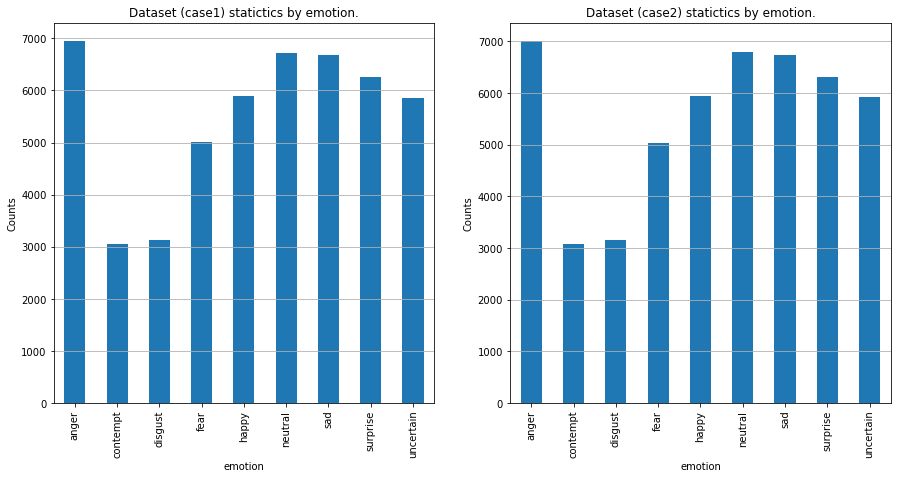

In [25]:
plt.figure(figsize=(15, 7))

# case 1: exlude all from df_err (0 or 2+ detected faces)
df_case1 = df.drop(df_err.index, axis=0)
print(f'Dataset (case1) size: {df_case1.shape[0]}')

plt.subplot(1, 2, 1)
df_case1.groupby('emotion')['mode'].count().plot.bar()
plt.title('Dataset (case1) statictics by emotion.')
plt.ylabel('Counts')
plt.grid(axis='y')

# case 2: exclude only where zero faces detected, trimmed files were already saved
df_case2 = df.drop(df_err[df_err['faces'] == 0].index, axis=0)
print(f'Dataset (case2) size: {df_case2.shape[0]}')

plt.subplot(1, 2, 2)
df_case2.groupby('emotion')['mode'].count().plot.bar()
plt.title('Dataset (case2) statictics by emotion.')
plt.ylabel('Counts')
plt.grid(axis='y')
plt.show()

Исправим пути к фотографиям с обрезанными лицами и обновим информацию по размерам фотографий.

In [26]:
# update image_path from train/ to processed/
df_case2['image_path'] = df_case2['image_path'].apply(lambda x: x.replace('train', 'processed', 1))

# update height/width/ratio for trimmed photos
img_info = []
for file in tqdm(df_case2.image_path):
    with Image.open(base_dir / file) as img:
        (w, h), mode = img.size, img.mode
        img_info.append((h, w, mode))
df_case2['height'], df_case2['width'], df_case2['mode'] = zip(*img_info)
df_case2['aspect_ratio'] = df_case2['width'] / df_case2['height']

100%|██████████| 49995/49995 [00:20<00:00, 2472.95it/s]


In [27]:
df_case2.describe(include='all')

,image_path,emotion,height,width,mode,aspect_ratio
count,49995,49995,49995.000000,49995.000000,49995,49995.000000
unique,49995,9,NaN,NaN,1,NaN
top,./processed/uncertain/4901.jpg,anger,NaN,NaN,RGB,NaN
freq,1,7016,NaN,NaN,49995,NaN
mean,NaN,NaN,464.042484,349.427123,NaN,0.753985
std,NaN,NaN,376.129172,286.679520,NaN,0.078037
min,NaN,NaN,85.000000,58.000000,NaN,0.432990
25%,NaN,NaN,220.000000,165.000000,NaN,0.700000
50%,NaN,NaN,334.000000,253.000000,NaN,0.743719
75%,NaN,NaN,581.000000,436.000000,NaN,0.796703


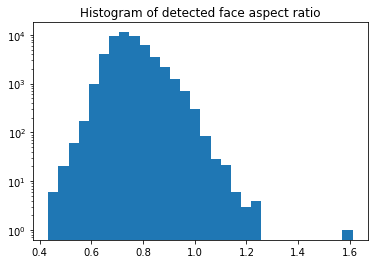

In [28]:
plt.hist(df_case2.aspect_ratio, bins=30, log=True)
plt.title('Histogram of detected face aspect ratio')
plt.show()

### Варианты обучения

Теперь у нас в наличии 2 возможных подхода к обучению:

1. Обучаем на сырых фото, на которых не было ошибки детектирования лица (задетектировано ровно одно лицо): `df_case1`.

    - выкинули 507 фотографий.
    - чуть больше возможностей по аугментации и модель не будет так зависима от алгоритма детектирования лица (если будет дальше применяться другой алгоритм, который обрезает мешьше или больше, чем в данном случае делает cv2).
    - фотографии уже отформатированы в очень близком к квадратному соотношению сторон (искажения при resize под размер CNN-классификатора минимальны).
    - после обучения рекомендуется подавать квадратный кадр (приводим bounding box к квадрату, но можем захватить лишнее) - хотя это надо еще проверить!

2. Обучаем на обрезанных фотографиях в соответствии с bounding box детектора: `df_case2`. 

    - выкинули 51 фотографию.
    - Отсутствие посторонних объектов (например, фрагменты других лиц) в кадре, лица примерно отцентрованы, что может положительно сказаться на качестве классификации.
    - недостатком является то, что кадры не обязательно имеют похожие соотношения сторон (при дальнейшем resize к квадратному размеру получим различные искажения пропорций лица для всего датасета).
    - после обучения просто вырезаем по bounding box.
    
Статистика по жанрам практически не изменилась.

### Задаем различные фильтры для дополнительной аугментации

Измененяем насыщенность цветов, добавляем размытие или случайный шум (гаусовый, пуассона, соль-и-перец). Для дальнейшего использования сохраним эти функции в отдельный файл `misc/custom_filters.py`

In [29]:
def add_noise(noise_typ, img):
    """Add noise with numpy."""
    image = img / 255.
    if noise_typ == "gauss":
        row, col, ch= image.shape
        mean = 0
        var = 0.002
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
#         gauss = gauss.reshape((row, col, ch))
#         print(image.shape, gauss.shape)
        out = gauss + image
        out =  np.clip(out, 0, 1)
    elif noise_typ == "s&p":
        row, col, ch = image.shape
        s_vs_p = 0.5
        amount = 0.02
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * row * col * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape[:2]]
        out[tuple(coords)] = np.random.uniform(0.6, 1.0)
        # Pepper mode
        num_pepper = np.ceil(amount* row * col * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape[:2]]
        out[tuple(coords)] = np.random.uniform(0, 0.4)
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        out = np.clip(noisy, 0, 1)
    return (out * 255).astype(np.uint8)


def apply_filter(filter_type, img):
    """Apply blur or color filter."""
#     image = Image.fromarray(np.round(img * 255).astype(np.uint8))
    image = Image.fromarray(img)
    if filter_type == 'blur':
        out = image.filter(filter=ImageFilter.BLUR)
    elif filter_type == 'color':
        enhancer = ImageEnhance.Color(image)
        out = enhancer.enhance(np.random.uniform(0.4, 1.3))
    elif filter_type == 'gblur':
        out = image.filter(ImageFilter.GaussianBlur(1))
    return np.array(out)


def random_transformation(image):
    """
    Transform image with random filter or noise.
    Image assumed to be an array of shape (h, w, ch) 
    and color values are in [0, 255] range.
    Always varies colors saluration, and add noise/blur with 60% propability.
    """
    transformations = [
        lambda x: add_noise('gauss', x),
        lambda x: add_noise('s&p', x),
        lambda x: add_noise('poisson', x),
        lambda x: apply_filter('blur', x),
        lambda x: apply_filter('gblur', x),
        lambda x: x, # no filter
    ]
    p = [0.12, 0.12, 0.12, 0.12, 0.12, 0.40]
    
    trans_fn = np.random.choice(transformations, p=p)
    return apply_filter('color', trans_fn(image.astype(np.uint8))).astype(image.dtype)

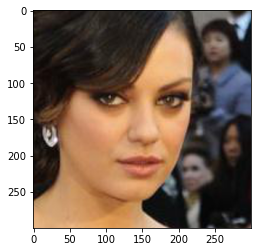

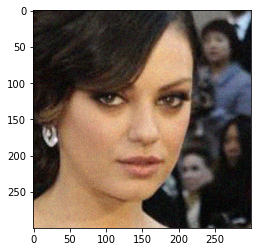

uint8


In [30]:
i=25321
file = df['image_path'][i]
with Image.open(base_dir / file) as image:
    img = image.convert('RGB').resize((300, 300))
    img = np.array(img)
    plt.imshow(img); plt.show()
    plt.imshow(random_transformation(img)); plt.show()
    print(random_transformation(img).dtype, )

### Разбиваем датасеты на обучающую и валидационную выборки

Вариант 1

In [87]:
# разделим датасет на обучающую и валидационную выборку
def stratified_split_ds(data, validation_split=0.2, seed=42):
    """Stratified split of dataframe base on column 'emotion'."""
    rnd_seed = np.random.RandomState(seed=seed)
    val_indices = []
    for category in data['emotion'].unique():
        sub_df = data[data['emotion'] == category]
        sub_val_len = int(sub_df.shape[0] * validation_split)
        cat_val_idx = rnd_seed.choice(sub_df.index, size=sub_val_len, replace=False)
        val_indices.extend(list(cat_val_idx))

    return data.drop(val_indices, axis=0), data.loc[val_indices,:]

df_case1_train, df_case1_test = stratified_split_ds(df_case1)
print(f'Train dataset size: {df_case1_train.shape[0]}')
print(f'Test dataset size: {df_case1_test.shape[0]}')

Train dataset size: 39634
Test dataset size: 9905


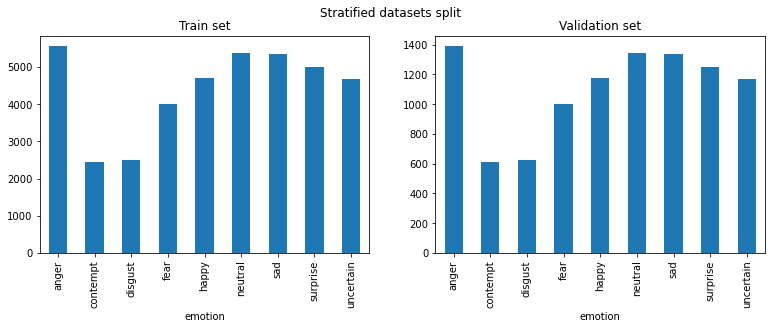

In [88]:
plt.figure(figsize=(13,4))
plt.suptitle('Stratified datasets split')
plt.subplot(1, 2, 1)
df_case1_train.groupby('emotion')['image_path'].count().plot.bar()
plt.title('Train set')
plt.subplot(1, 2, 2)
df_case1_test.groupby('emotion')['image_path'].count().plot.bar()
plt.title('Validation set')
plt.show()

Вариант 2

In [89]:
df_case2_train, df_case2_test = stratified_split_ds(df_case2)
print(f'Train dataset size: {df_case2_train.shape[0]}')
print(f'Test dataset size: {df_case2_test.shape[0]}')

Train dataset size: 39999
Test dataset size: 9996


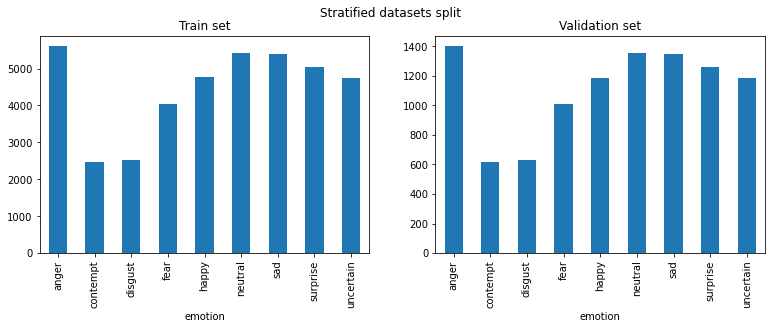

In [90]:
plt.figure(figsize=(13,4))
plt.suptitle('Stratified datasets split')
plt.subplot(1, 2, 1)
df_case2_train.groupby('emotion')['image_path'].count().plot.bar()
plt.title('Train set')
plt.subplot(1, 2, 2)
df_case2_test.groupby('emotion')['image_path'].count().plot.bar()
plt.title('Validation set')
plt.show()

### Сохраним данные для работы с нейросетями

In [91]:
dfs1 = [df_case1_train, df_case1_test]
dfs2 = [df_case2_train, df_case2_test]
for i, datas in enumerate(zip(dfs1, dfs2)):
    name = 'train' if i == 0 else 'test'
    datas[0].to_pickle(base_dir / f"dataframe_case1_{name}.pkl")
    datas[1].to_pickle(base_dir / f"dataframe_case2_{name}.pkl")